In [1]:
from tensorflow.keras.datasets import mnist #Загружаем базу mnist
from tensorflow.keras.datasets import cifar10 #Загружаем базу cifar10
from tensorflow.keras.datasets import cifar100 #Загружаем базу cifar100
from tensorflow.keras.models import Model

import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential #Сеть прямого распространения
from tensorflow.keras.applications.vgg16 import VGG16
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Conv3D, ConvLSTM2D, GlobalAveragePooling2D, TimeDistributed
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout3D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
from google.colab import files #Для загрузки своей картинки
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Для отрисовки графиков
from PIL import Image #Для отрисовки изображений
import random #Для генерации случайных чисел 
import math # Для округления
import os #Для работы с файлами 
import json
# подключем диск
from google.colab import drive

%matplotlib inline

In [3]:
path = '/content/drive/My Drive/DATAS/dataBodyLanguage/'
IMG_WIDTH = 1920
IMG_HEIGHT = 1080
val_split = 0.25
words = 'всего деньги зачем здесь какой написать нормально нравится нужно пожалуйста'.split(' ')
n = len(words)

## DataFrame  + CatBoost

In [27]:
!pip install catboost

     |████████████████████████████████| 66.2MB 46kB/s 


In [184]:
X_train = []
X_test = []
Y_train = []
Y_test = []
for i, word in enumerate(words) :
  now_path = path + 'DataFrames/' + word
  print(word)
  X = []
  Y = []
  for video_name in os.listdir(now_path) :
    sz = len(os.listdir(now_path + '/' + video_name))
    indexes = [sz // 2]
    for_x = []
    dirs = os.listdir(now_path + '/' + video_name)
    for ind in indexes :
      path_to_json = now_path + '/' + video_name + '/' + dirs[ind]
      with open(path_to_json, 'r') as myfile:
        data = myfile.read()
      obj = json.loads(data)
      
      for_x = for_x + obj['people'][0]['pose_keypoints_2d'] + obj['people'][0]["hand_left_keypoints_2d"] + obj['people'][0]["hand_right_keypoints_2d"]
    X.append(for_x)
    Y.append(i)
  n_videos = len(X)
  X_train += X[:-int(val_split * n_videos)]
  X_test += X[-int(val_split * n_videos) :]
  
  Y_train += Y[:-int(val_split * n_videos)]
  Y_test += Y[-int(val_split * n_videos) :]

всего
деньги
зачем
здесь
какой
написать
нормально
нравится
нужно
пожалуйста


In [185]:
def getDataFromList(X, Y) :
  data = pd.DataFrame(X)
  shape = data.shape
  #расчитаем относительные координаты и удалим столбцы, в которых хранится вероятность присутствия точки
  for i in range(shape[1]) :
    if i % 3 == 2 :
      del data[i]
      continue
    if (i > 2) :
      data.loc[data[i] != 0, i] -= data[i % 3]
  data[0] = data[1] = 0
  data['ans'] = Y
  return data

In [186]:
df_Test, df_Train = getDataFromList(X_test, Y_test), getDataFromList(X_train, Y_train)

In [187]:
df_Train.head()

,0,1,3,4,6,7,9,10,12,13,15,16,18,19,21,22,24,25,27,28,30,31,33,34,36,37,39,40,42,43,45,46,48,49,51,52,54,55,57,58,...,142,144,145,147,148,150,151,153,154,156,157,159,160,162,163,165,166,168,169,171,172,174,175,177,178,180,181,183,184,186,187,189,190,192,193,195,196,198,199,ans
0,0,0,8.66,220.742,-147.273,235.450,-188.550,462.075,-188.608,547.511,164.65,212.025,294.13,450.407,267.70,285.537,23.49,747.613,-76.701,753.525,0.0,0.0,0.0,0.0,132.29,750.550,0.0,0.0,0.0,0.0,-29.63,-29.362,40.93,-26.499,-73.712,2.983,79.30,2.849,0.0,0.0,...,565.564,-197.923,563.874,-173.417,564.719,-154.826,565.564,-214.824,619.647,-212.289,626.407,-198.768,612.887,-186.937,599.366,-198.768,627.252,-179.332,641.618,-158.206,618.802,-145.530,586.690,-183.557,634.013,-154.826,626.407,-145.530,606.126,-138.770,586.690,-167.502,630.632,-149.756,622.182,-143.840,601.056,-137.925,587.535,0
1,0,0,0.08,211.976,-156.004,226.582,-205.954,453.230,-194.222,515.176,150.17,206.133,265.02,470.969,229.59,347.374,8.93,738.759,-100.026,744.617,0.0,0.0,0.0,0.0,120.66,741.680,0.0,0.0,0.0,0.0,-38.23,-29.349,32.32,-26.485,-82.341,-2.809,73.57,-0.010,0.0,0.0,...,499.860,-213.338,512.631,-212.486,517.739,-193.756,544.984,-210.784,577.338,-188.647,558.607,-173.322,535.619,-157.145,516.888,-193.756,586.703,-170.768,571.378,-152.037,541.579,-138.414,512.631,-181.836,589.257,-152.037,572.229,-145.226,542.430,-129.900,520.294,-169.065,585.000,-146.077,572.229,-134.157,558.607,-130.752,545.836,0
2,0,0,2.94,214.755,-156.020,223.620,-203.159,444.455,-188.395,529.736,153.11,208.878,253.11,467.970,247.37,367.853,11.84,735.739,-94.124,744.585,0.0,0.0,0.0,0.0,123.57,729.887,0.0,0.0,0.0,0.0,-38.29,-26.699,29.59,-26.547,-85.256,-2.863,70.70,-2.868,0.0,0.0,...,536.341,-188.493,533.027,-205.061,523.087,-186.836,552.908,-207.546,589.357,-181.038,575.275,-162.813,558.707,-142.932,542.968,-189.321,600.954,-166.127,591.842,-140.447,558.707,-124.708,537.169,-178.553,603.439,-147.074,587.700,-133.820,559.535,-121.394,541.311,-166.127,600.126,-143.761,586.872,-131.335,570.304,-121.394,559.535,0
3,0,0,0.01,208.957,-158.876,220.752,-208.956,444.397,-173.660,515.119,153.00,203.005,258.97,473.863,214.83,373.811,8.93,718.158,-100.036,724.018,0.0,0.0,0.0,0.0,120.57,718.165,0.0,0.0,0.0,0.0,-38.29,-32.440,29.51,-32.312,-85.262,-5.942,73.51,-8.792,0.0,0.0,...,495.579,-159.490,519.961,-122.496,521.643,-101.478,514.076,-172.101,575.451,-146.038,559.477,-125.859,540.980,-107.363,532.572,-155.286,587.222,-125.859,575.451,-101.478,540.980,-80.459,526.687,-144.356,588.903,-112.407,575.451,-98.955,547.706,-80.459,528.369,-131.745,587.222,-104.840,575.451,-96.433,560.317,-92.229,547.706,0
4,0,0,0.02,209.026,-156.098,220.705,-203.206,441.462,-208.954,532.641,155.95,206.026,247.28,468.051,261.97,403.232,11.82,726.975,-97.110,732.870,0.0,0.0,0.0,0.0,117.67,724.053,0.0,0.0,0.0,0.0,-35.38,-29.510,32.34,-29.412,-82.406,-5.721,70.60,-5.744,0.0,0.0,...,516.357,-219.960,519.669,-214.164,541.199,-176.900,556.105,-247.287,587.572,-227.413,593.368,-208.367,579.291,-179.384,559.417,-232.381,598.337,-212.507,614.898,-186.837,586.744,-168.619,568.526,-219.132,605.789,-190.149,610.758,-180.212,587.572,-161.995,572.666,-202.571,606.617,-186.837,609.102,-175.244,592.540,-163.651,575.150,0


In [188]:
print(df_Train.shape)
print(df_Test.shape)

(149, 135)
(45, 135)


In [273]:
from catboost import Pool,CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                                    learning_rate=0.05,
                                    depth=3,
                                    loss_function='MultiClass',
                                    eval_metric='MultiClass',
                                    random_seed=123456,
                                    devices='0-3',
                                    task_type="GPU"
                                    )

In [274]:
D_train = Pool(df_Train.drop('ans', axis=1), df_Train['ans'])
model.fit(D_train, verbose = False, plot = False)

In [275]:
val_accuracy = np.sum(df_Test['ans'] == model.predict(df_Test.drop('ans', axis=1)).flatten()) / df_Test.shape[0]
accuracy = np.sum(df_Train['ans'] == model.predict(df_Train.drop('ans', axis=1)).flatten()) / df_Train.shape[0]
print('accuracy = ', accuracy)
print('val_accuracy = ', val_accuracy)

accuracy =  0.9395973154362416
val_accuracy =  0.7777777777777778


## DataFrame + Dense

В данном разделе попробуем применить нейронную сеть для распознавания жестов

In [5]:
X_train = []
X_test = []
Y_train = []
Y_test = []
for i, word in enumerate(words) :
  now_path = path + 'DataFrames/' + word
  print(word)
  X = []
  Y = []
  for video_name in os.listdir(now_path) :
    sz = len(os.listdir(now_path + '/' + video_name))
    for json_name in os.listdir(now_path + '/' + video_name)[sz // 2 : sz // 2 + 1] :
      path_to_json = now_path + '/' + video_name + '/' + json_name
      with open(path_to_json, 'r') as myfile:
        data=myfile.read()
      obj = json.loads(data)
      Y.append(utils.to_categorical(i, n))
      X.append(obj['people'][0]['pose_keypoints_2d'] + obj['people'][0]["hand_left_keypoints_2d"] + obj['people'][0]["hand_right_keypoints_2d"] )
  n_videos = len(X)
  X_train += X[:-int(val_split * n_videos)]
  X_test += X[-int(val_split * n_videos) :]
  
  Y_train += Y[:-int(val_split * n_videos)]
  Y_test += Y[-int(val_split * n_videos) :]

всего
деньги
зачем
здесь
какой
написать
нормально
нравится
нужно
пожалуйста


In [9]:
IMG_WIDTH = 1920
IMG_HEIGHT = 1080

In [12]:
def showPoints(X) :
  points = []
  for i in range(2, len(X), 3) :
    if (X[i] > 0) :
      points.append(np.array([X[i - 2], IMG_HEIGHT - X[i - 1]]))
  points = np.array(points)
  plt.scatter(points[:, 0], points[:, 1])
  plt.show()

In [7]:
def makeScaleRelative(X) :
  #нормализируем данные, чтобы координаты пикселя были от 0 до 1 по х и у
  for i in range(75) : 
    if (i % 3 == 2) :
      continue
    if (i % 2 == 0) :
      X[:, i] /= IMG_WIDTH
    else :
      X[:, i] = IMG_HEIGHT
      X[:, i] /= IMG_HEIGHT
  #теперь расчитаем расположение точки тела относительно головы (нулевой точки)
  X_res = np.zeros((X.shape[0], 50))
  j = 0
  for i in range(0, 75, 3) :
    if (X[0, i] == 0) :
      j += 2
      continue
    if (i > 2) :
      X[X[:, i] > 0, i] -= X[X[:, i] > 0, 0]
      X[X[:, i + 1] > 0, i + 1] -= X[X[:, i + 1] > 0, 1]
    X_res[:, j] = X[:, i]
    j += 1
    X_res[:, j] = X[:, i + 1]
    j += 1
  X_res[:,0] = 0;
  X_res[:,1] = 0;
  return X_res

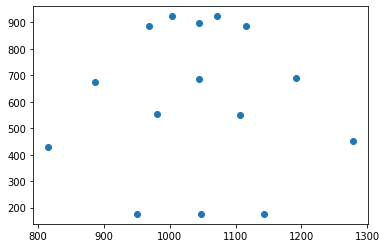

In [13]:
showPoints(X[0][:76])

In [14]:
Y_train = np.array(Y_train)
Y_test  = np.array(Y_test)
X_train = makeScaleRelative(np.array(X_train))
X_test  = makeScaleRelative(np.array(X_test))

In [15]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(149, 50)
(45, 50)
(149, 10)
(45, 10)


In [16]:
import tensorflow as tf
my_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=7, min_lr=0.00001),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_best.h5', save_best_only=True),
]

In [ ]:
import sklearn
X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train, random_state = 0)

In [17]:
randomize = np.arange(len(X_train))
np.random.shuffle(randomize)
X_train = X_train[randomize]
Y_train = Y_train[randomize]

Epoch 1/80
15/15 [==============================] - 0s 17ms/step - loss: 2.3371 - accuracy: 0.3154 - val_loss: 2.4790 - val_accuracy: 0.0889
Epoch 2/80
15/15 [==============================] - 0s 6ms/step - loss: 1.3592 - accuracy: 0.5101 - val_loss: 2.4599 - val_accuracy: 0.0889
Epoch 3/80
15/15 [==============================] - 0s 6ms/step - loss: 1.4786 - accuracy: 0.4832 - val_loss: 2.4117 - val_accuracy: 0.0889
Epoch 4/80
15/15 [==============================] - 0s 7ms/step - loss: 1.3373 - accuracy: 0.5302 - val_loss: 2.4044 - val_accuracy: 0.0889
Epoch 5/80
15/15 [==============================] - 0s 7ms/step - loss: 1.1289 - accuracy: 0.6174 - val_loss: 2.4014 - val_accuracy: 0.0889
Epoch 6/80
15/15 [==============================] - 0s 6ms/step - loss: 1.3945 - accuracy: 0.5503 - val_loss: 2.3759 - val_accuracy: 0.0889
Epoch 7/80
15/15 [==============================] - 0s 7ms/step - loss: 1.1162 - accuracy: 0.6577 - val_loss: 2.3732 - val_accuracy: 0.0889
Epoch 8/80
15/15 [=

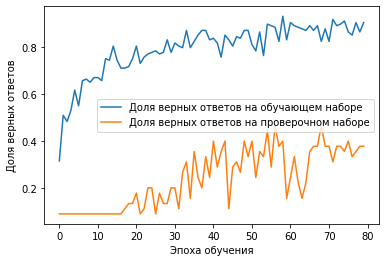

In [26]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
          validation_data = (X_test, Y_test),
          batch_size = 10,
          #callbacks = my_callbacks,
          epochs = 80)
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()